## Dogs v Cats

In [15]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *

In [16]:
PATH = "data/idcard3/dataset/"
#sz = 224
sz=300
arch = resnet34
bs = 64

In [17]:
m = arch(True)

In [18]:
m

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (b

In [19]:
m = nn.Sequential(*children(m)[:-2], 
                  nn.Conv2d(512, 2, 3, padding=1), 
                  nn.AdaptiveAvgPool2d(1), Flatten(), 
                  nn.LogSoftmax())

In [20]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs)

In [21]:
learn = ConvLearner.from_model_data(m, data)

RuntimeError: cuda runtime error (59) : device-side assert triggered at /opt/conda/conda-bld/pytorch_1518244421288/work/torch/lib/THC/generic/THCTensorCopy.c:20

In [11]:
learn.freeze_to(-4)

In [12]:
m[-1].trainable

True

In [13]:
m[-4].trainable

True

In [14]:
learn.fit(0.1, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  0%|          | 0/25 [00:00<?, ?it/s]


RuntimeError: cuda runtime error (59) : device-side assert triggered at /opt/conda/conda-bld/pytorch_1518244421288/work/torch/lib/THC/generic/THCStorage.c:36

In [11]:
learn.fit(0.01, 1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.293      0.93298    0.90625   



[0.9329802, 0.90625]

In [10]:
learn.load('224_all_123')

KeyError: 'unexpected key "10.weight" in state_dict'

## CAM

In [12]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [69]:
x,y = next(iter(data.val_dl))

In [70]:
x,y = x[None,1], y[None,1]
vx = Variable(x.cuda(), requires_grad=True)

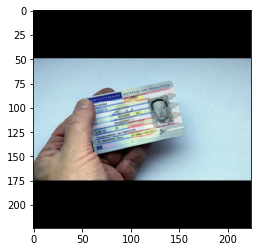

In [71]:
dx = data.val_ds.denorm(x)[0]
plt.imshow(dx);

In [72]:
#m[4]

In [73]:
#for name, module in m.named_children():
#    print(f'{name} : {module}')

In [74]:
sf = SaveFeatures(m[-4])
py = m(Variable(x.cuda()))
sf.remove()

py = np.exp(to_np(py)[0]); py

array([1., 0.], dtype=float32)

In [76]:
#sf.features[0].data.shape

torch.Size([2, 7, 7])

In [107]:
feat = sf.features[0].data.cpu().numpy()

In [78]:
#feat.shape

(2, 7, 7)

In [79]:
#feat = np.maximum(0, sf.features[0])
#feat.shape

In [80]:
f2=np.dot(np.rollaxis(feat,0,3), py)
f2-=f2.min()
f2/=f2.max()
f2

array([[0.02324, 0.07095, 0.09709, 0.09971, 0.07772, 0.04072, 0.00316],
       [0.14272, 0.29083, 0.38452, 0.37632, 0.29631, 0.16519, 0.05589],
       [0.29326, 0.57685, 0.7644 , 0.75028, 0.57422, 0.31874, 0.11302],
       [0.38972, 0.76827, 1.     , 0.97517, 0.73781, 0.39914, 0.13591],
       [0.36215, 0.70526, 0.91514, 0.88354, 0.64873, 0.33629, 0.10433],
       [0.239  , 0.46351, 0.59956, 0.56721, 0.4057 , 0.19568, 0.05334],
       [0.08347, 0.17072, 0.22192, 0.20276, 0.13718, 0.05448, 0.     ]], dtype=float32)

/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


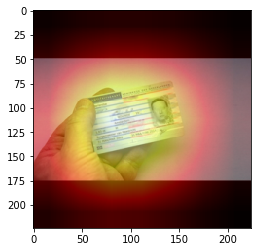

In [81]:
plt.imshow(dx)
plt.imshow(scipy.misc.imresize(f2, dx.shape), alpha=0.5, cmap='hot');

In [108]:
img_iter = iter(data.val_dl)

/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  from ipykernel import kernelapp as app


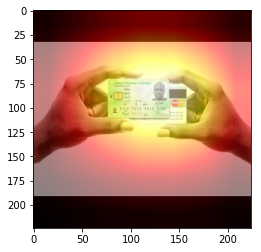

In [111]:
x,y = next(img_iter)
x,y = x[None,1], y[None,1]
vx = Variable(x.cuda(), requires_grad=True)
dx = data.val_ds.denorm(x)[0]
#plt.imshow(dx);
sf = SaveFeatures(m[-4])
py = m(Variable(x.cuda()))
sf.remove()
py = np.exp(to_np(py)[0])
feat = sf.features[0].data.cpu().numpy()
f2=np.dot(np.rollaxis(feat,0,3), py)
f2-=f2.min()
f2/=f2.max()
plt.imshow(dx)
plt.imshow(scipy.misc.imresize(f2, dx.shape), alpha=0.5, cmap='hot');